In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# https://lmu.box.com/s/pw28hs4vxf91uvoaykxsfroj95neq61r
train = pd.read_csv("train.csv")
print(train.shape)

(891, 12)


In [3]:
# Check for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=["Train"])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


In [4]:
# Drop the Cabin feature since it is missing a lot of the data
train.pop('Cabin')
train.pop('Name')
train.pop('Ticket')
train.shape

(891, 9)

In [5]:
# Fill in missing Age values with mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [6]:
# Fill in missing Embarked values with most common value
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [7]:
# Convert the values in the 'Pclass' column of the DataFrame 'train' to strings
train['Pclass'] = train['Pclass'].apply(str)

In [8]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
 for_dummy = train.pop(col)
 train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

train

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.000000,1,0,7.2500,False,False,True,False,True,False,False,True
1,2,1,38.000000,1,0,71.2833,True,False,False,True,False,True,False,False
2,3,1,26.000000,0,0,7.9250,False,False,True,True,False,False,False,True
3,4,1,35.000000,1,0,53.1000,True,False,False,True,False,False,False,True
4,5,0,35.000000,0,0,8.0500,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.000000,0,0,13.0000,False,True,False,False,True,False,False,True
887,888,1,19.000000,0,0,30.0000,True,False,False,True,False,False,False,True
888,889,0,29.699118,1,2,23.4500,False,False,True,True,False,False,False,True
889,890,1,26.000000,0,0,30.0000,True,False,False,False,True,True,False,False


In [9]:
# Prepare data for training models
labels = train.pop('Survived')

In [10]:
# For testing, we choose to split our data to 75% train and 25% for test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

In [15]:
# Fit a decision tree with default parameters to get a baseline idea of the performance
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

In [16]:
# We will use AUC (Area Under Curve) as the evaluation metric. 
# Our target value is binary so it’s a binary classification problem. 
# AUC is a good way for evaluation for this type of problems.
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7840810293861937

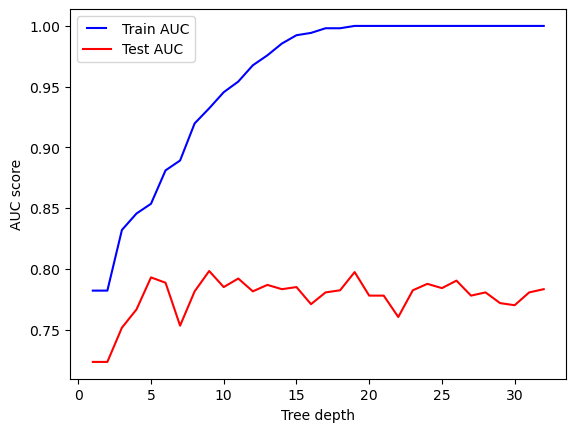

In [22]:
max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

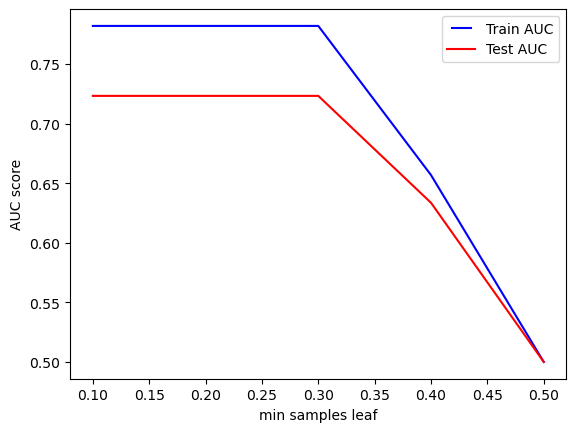

In [23]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(x_train, y_train)
    
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

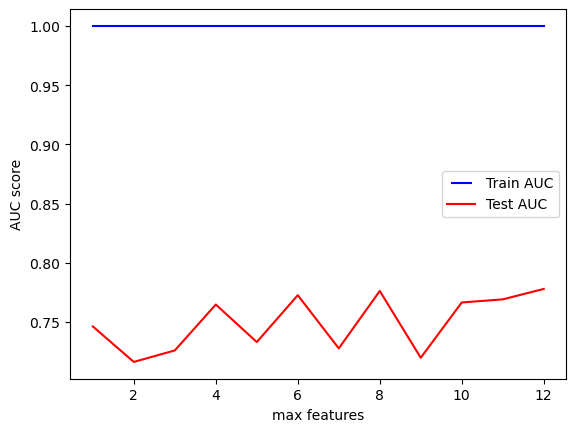

In [24]:
max_features = list(range(1, train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(x_train, y_train)
    
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()
